In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time
from IPython.display import Audio
from config import PARAS
from mel_dealer import mel_converter



MIX_PATH = '../DSD100/Mixtures'
SRC_PATH = '../DSD100/Sources'

# Get File Paths

- Path Dictionary
    - Music File Index
        - Track 1 -> path
        - Track 2 -> path

In [2]:
dev_file_paths = dict()
test_file_paths = dict()

for (dirpath, dirnames, filenames) in os.walk(MIX_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            test_file_paths[file_name] = dict()
            test_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            dev_file_paths[file_name] = dict()
            dev_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]

for (dirpath, dirnames, filenames) in os.walk(SRC_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                test_file_paths[file_name][track] = dirpath + '/' + trackname
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                dev_file_paths[file_name][track] = dirpath + '/' + trackname
    

# Build Feature Extractor

In [3]:
PARAS.SR, PARAS.N_FFT, PARAS.N_MEL, PARAS.SAMPLE_TIME

(16000, 512, 128, 1)

In [4]:
test_path = dev_file_paths['056']
test_path, len(dev_file_paths)

({'mix': '../DSD100/Mixtures/Dev/056 - Arise - Run Run Run/mixture.wav',
  'vocals': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/vocals.wav',
  'drums': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/drums.wav',
  'other': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/other.wav',
  'bass': '../DSD100/Sources/Dev/056 - Arise - Run Run Run/bass.wav'},
 50)

## The Points
- Do not use the origin mix track, using the sum of vocal and background tracks and return a new mixed track, because the old track is not ensured the normalization
### Remove vocal silence part ( slience is useless for model training)

In [7]:
def remove_silence(vocal, target_track):
    """
    This function remove slience part
    notice it's not an in place dealer
    """
    remove_list = list()
    for i, point in enumerate(vocal):
        if 10**-4 > abs(point): # be careful of the silence part shreshold
            remove_list.append(i)
    vocal_out = np.delete(vocal, remove_list)
    target_track_out = np.delete(target_track, remove_list)
    return vocal_out, target_track_out

### Extract the mix/target signals

In [5]:
def sound_tracks_extractor(file_path):
    """
    Take in a file path dictionary, return:
    (Normalized track)
    vocal track as target
    mixed track as input
    """
    signals = dict()
    for key in file_path:
        if key == 'mix':
            continue
        signals[key], _ = librosa.load(file_path.get(key), sr = PARAS.SR)
        signals[key] = librosa.util.normalize(signals.get(key))
        
    vocal_track = signals.get('vocals')
    return_vocal, _ = remove_silence(vocal_track, vocal_track)
    background_track = np.zeros(len(return_vocal))

    for key in signals:
        if 'vocals' == key:
            continue
        _, signals[key] = remove_silence(vocal_track, signals.get(key))
        background_track = signals.get(key) if not len(background_track) else background_track + signals.get(key)
    
    mix_track = background_track + return_vocal
    
    return return_vocal, background_track, mix_track

### Generate chunks Spectrogram
#### Use MelConverter

In [ ]:
b =  sound_tracks_extractor(test_path)

In [ ]:
# useless, for backup
def signal_divider(signal, sr=PARAS.SR, time=PARAS.SAMPLE_TIME):
    """
    This one takes signal in and devided them in 1s frames
    """
    sample_length = sr * time
    n_frames = len(signal) // sample_length
    new_list = list()
    for i in range(n_frames):
        new_list.append(signal[i*sample_length:(i+1)*sample_length])
    return new_list

#### create mel_spectrogram (150 * 150 frames)

In [19]:
def frame_feature_extractor(signal, mel_converter=mel_converter):
    """
    Takes in new signals and create mel chunks 
    """
    S = mel_converter.signal_to_melspec(signal)
    if not S.shape[0] % PARAS.N_MEL == 0:
        S = S[:-1 * (S.shape[0] % PARAS.N_MEL)] # divide the mel spectrogram
        
    chunk_num = int(S.shape[0] / PARAS.N_MEL)
    mel_chunks = np.split(S, chunk_num) # create 150 * 150 data frames
    return mel_chunks, chunk_num

In [20]:
vocal_ct, chunk_n = frame_feature_extractor(b[0])
bg_ct, _ = frame_feature_extractor(b[1])
mix_ct, _ = frame_feature_extractor(b[2])

In [21]:
vocal_ct[0].shape, bg_ct[0].shape, mix_ct[0].shape

((150, 150), (150, 150), (150, 150))

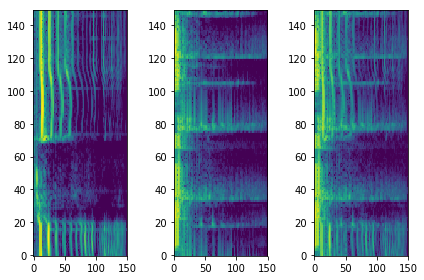

In [22]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(vocal_ct[56], aspect='auto', origin='lower')
plt.subplot(1, 3, 2)
plt.imshow(bg_ct[56], aspect='auto', origin='lower')
plt.subplot(1, 3, 3)
plt.imshow(mix_ct[56], aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

# Build dataset

In [84]:
file_paths = dict(list(dev_file_paths.items())
                  + list(test_file_paths.items()))

## load data
Load data in to small databases

In [85]:
import time

print("start loading data...")
file_count = 100
chunk_count = 0

for key, file_dict in file_paths.items():
    ss_time = time.time()
    count = 0
    vocal_signal, bg_signal, mix_signal = sound_tracks_extractor(file_dict)
    vocal_chunks, cn = frame_feature_extractor(vocal_signal)
    mix_chunks, _ = frame_feature_extractor(mix_signal)
    bg_chunks, _ = frame_feature_extractor(bg_signal)
    
    c_setpath = PARAS.DATASET_PATH + '{0}.h5'.format(key)
    c_dataset = h5py.File(c_setpath, 'a')
    
    c_dataset.create_dataset('mix', 
                       shape=(cn, 150, 150),   
                       dtype=np.float32)
    
    c_dataset.create_dataset('bg', 
                       shape=(cn, 150, 150), 
                       dtype=np.float32)

    c_dataset.create_dataset('vocal', 
                           shape=(cn, 150, 150), 
                           dtype=np.float32)
    
    for idx in range(cn):
        c_dataset['vocal'][count] = vocal_chunks[idx]
        c_dataset['mix'][count] = mix_chunks[idx]
        c_dataset['bg'][count] = bg_chunks[idx]
        count += 1
        chunk_count += 1
    
    file_count -= 1
    epoch_s = round(time.time() - ss_time, 2)
    print("=>${0}[{1}s|LEFT:{2}|CHUNK:{3}] ".format(key, epoch_s, file_count, chunk_count), end="\r", flush=True)
    c_dataset.close()
print("TOTAL CHUNK: {0}".format(chunk_count))

start loading data...
TOTAL CHUNK: 142570|CHUNK:14257]   


## Create Datasets
### Create all in one dataset

In [9]:
all_setpath = PARAS.DATASET_PATH + 'all.h5'
all_dataset = h5py.File(all_setpath, 'a')

In [10]:
chunk_count = 16717
all_dataset.create_dataset('mix', 
                       shape=(chunk_count, PARAS.N_MEL, PARAS.N_MEL), 
                       dtype=np.float32)

all_dataset.create_dataset('vocal', 
                       shape=(chunk_count, PARAS.N_MEL, PARAS.N_MEL), 
                       dtype=np.float32)

all_dataset.create_dataset('bg', 
                       shape=(chunk_count, PARAS.N_MEL, PARAS.N_MEL), 
                       dtype=np.float32)

<HDF5 dataset "bg": shape (16717, 128, 128), type "<f4">

In [11]:
count = 0
for (dirpath, dirnames, filenames) in os.walk(PARAS.DATASET_PATH):
    if filenames:
        for set_name in filenames:
            if 'h5' not in set_name or 'all' in set_name:
                continue
            set_path = PARAS.DATASET_PATH + set_name
            tmp_dataset = h5py.File(set_path, 'r')
            tmp_count = tmp_dataset['vocal'].shape[0]
            for i in range(tmp_count):
                all_dataset['mix'][count] = tmp_dataset['mix'][i]
                all_dataset['vocal'][count] = tmp_dataset['vocal'][i]
                all_dataset['bg'][count] = tmp_dataset['bg'][i]
                count += 1
            tmp_dataset.close()
all_dataset.close()
print(count)

16717


# Split Dataset

In [12]:
import random
all_setpath = PARAS.DATASET_PATH + 'all.h5'
all_dataset = h5py.File(all_setpath, 'r')
chunk_count = 14257

train_set = PARAS.DATASET_PATH+'train.h5'
valid_set = PARAS.DATASET_PATH+'valid.h5'
test_set = PARAS.DATASET_PATH+'test.h5'

In [13]:
train_file = int(chunk_count * 0.8)
valid_file = int(chunk_count * 0.1)
test_file = chunk_count - train_file - valid_file
print(train_file, valid_file, test_file)

11405 1425 1427


In [14]:
files = [int(a) for a in [train_file, valid_file, test_file]]
sets = [train_set, valid_set, test_set]
print(files)

[11405, 1425, 1427]


In [15]:
idx = [i for i in range(chunk_count)]
random.seed(516)
random.shuffle(idx)

In [16]:
train_idx = idx[:files[0]]
valid_idx = idx[files[0]: files[0]+files[1]]
test_idx = idx[-files[2]:]
indices = [train_idx, valid_idx, test_idx]

In [17]:
for i, dset in enumerate(sets):
    s_set = h5py.File(dset, 'a')
    indice = indices[i]
    file_num = files[i]
    
    s_set.create_dataset('vocal', shape=(file_num, PARAS.N_MEL, PARAS.N_MEL), dtype=np.float32)
    s_set.create_dataset('mix', shape=(file_num, PARAS.N_MEL, PARAS.N_MEL), dtype=np.float32)
    s_set.create_dataset('bg', shape=(file_num, PARAS.N_MEL, PARAS.N_MEL), dtype=np.float32)
    
    count = 0
    for i in indice:
        s_set['vocal'][count] = all_dataset['vocal'][i]
        s_set['mix'][count] = all_dataset['mix'][i]
        s_set['bg'][count] = all_dataset['bg'][i]
        count += 1
        
        if count % 100 == 0:
            print('=>{0}'.format(count), end="")
    
    s_set.close()
    print()  
    print('Create Separate Datasets {0}'.format(dset))

=>100=>200=>300=>400=>500=>600=>700=>800=>900=>1000=>1100=>1200=>1300=>1400=>1500=>1600=>1700=>1800=>1900=>2000=>2100=>2200=>2300=>2400=>2500=>2600=>2700=>2800=>2900=>3000=>3100=>3200=>3300=>3400=>3500=>3600=>3700=>3800=>3900=>4000=>4100=>4200=>4300=>4400=>4500=>4600=>4700=>4800=>4900=>5000=>5100=>5200=>5300=>5400=>5500=>5600=>5700=>5800=>5900=>6000=>6100=>6200=>6300=>6400=>6500=>6600=>6700=>6800=>6900=>7000=>7100=>7200=>7300=>7400=>7500=>7600=>7700=>7800=>7900=>8000=>8100=>8200=>8300=>8400=>8500=>8600=>8700=>8800=>8900=>9000=>9100=>9200=>9300=>9400=>9500=>9600=>9700=>9800=>9900=>10000=>10100=>10200=>10300=>10400=>10500=>10600=>10700=>10800=>10900=>11000=>11100=>11200=>11300=>11400
Create Separate Datasets ../Dataset/train.h5
=>100=>200=>300=>400=>500=>600=>700=>800=>900=>1000=>1100=>1200=>1300=>1400
Create Separate Datasets ../Dataset/valid.h5
=>100=>200=>300=>400=>500=>600=>700=>800=>900=>1000=>1100=>1200=>1300=>1400
Create Separate Datasets ../Dataset/test.h5
